# Train Reacher Agent

## Install Requirements

In [1]:
!pip -q install ./python

tensorflow 1.7.1 has requirement numpy>=1.13.3, but you'll have numpy 1.12.1 which is incompatible.
ipython 6.5.0 has requirement prompt-toolkit<2.0.0,>=1.0.15, but you'll have prompt-toolkit 2.0.10 which is incompatible.


### Import Libraries

In [2]:
seed = 86

import torch, random
random.seed(seed)
import torch.nn as nn
torch.manual_seed(seed)

from collections import namedtuple
from tqdm import tqdm_notebook
from workspace_utils import active_session
import matplotlib.pyplot as plt

from unityagents import UnityEnvironment
import numpy as np
np.random.seed(seed)

### Define Network

In [3]:
class Critic(nn.Module):
    def __init__(self, n_state, n_hidden = [128, 128], n_action=0):
        super(Critic, self).__init__()
        self.n_state = n_state
        self.n_hidden = n_hidden
        self.bn1 = nn.BatchNorm1d(n_state)
        self.fc1 = nn.Linear(n_state, n_hidden[0])
        self.fc2 = nn.Linear(n_hidden[0]+n_action, n_hidden[1])
        self.fc3 = nn.Linear(n_hidden[1], 1)
        self.fc3.weight.data.uniform_(-3e-3, 3e-3)
        self.relu = nn.ReLU()
    def forward(self, state, action):
        x = state
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(torch.cat((x, action), dim=1)))
        x = self.fc3(x)
        return x

In [4]:
class Actor(nn.Module):
    def __init__(self, n_state, n_action, n_hidden = [128, 128]):
        super(Actor, self).__init__()
        self.n_state = n_state
        self.n_hidden = n_hidden
        self.n_action= n_action
        self.bn1 = nn.BatchNorm1d(n_state)
        self.fc1 = nn.Linear(n_state, n_hidden[0])
        self.bn2 = nn.BatchNorm1d(n_hidden[0])
        self.fc2 = nn.Linear(n_hidden[0], n_hidden[1])
        self.bn3 = nn.BatchNorm1d(n_hidden[1])
        self.fc3 = nn.Linear(n_hidden[1], n_action)
        self.fc3.weight.data.uniform_(-3e-3, 3e-3)
        self.relu = nn.ReLU()
        self.tanh = nn.Tanh()
    def forward(self, state):
        x = self.relu(self.fc1(state))
        x = self.relu(self.fc2(x))
        x = self.tanh(self.fc3(x))                           
        return x

### Define Replay Buffer

In [5]:
Transition = namedtuple('Transition',
                        ('state', 'action', 'next_state', 'reward', 'done'))


class ReplayMemory(object):

    def __init__(self, capacity):
        self.capacity = capacity
        self.memory = []
        self.position = 0

    def push(self, *args):
        """Saves a transition."""
        if len(self.memory) < self.capacity:
            self.memory.append(None)
        self.memory[self.position] = Transition(*args)
        self.position = int((self.position + 1) % self.capacity)

    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)

    def __len__(self):
        return len(self.memory)

### Initialize Hyperparameters

In [6]:
replay_capacity = 1e6
lr_actor = 1e-3
lr_critic = 1e-4
weight_decay_critic = 0
discount_factor = 0.9
tau = 1e-3
batch_size = 256
noise_std_start = 1
noise_std_decay = 0.96
noise_std_min = 0.01
episodes = 1000
max_t = 10000
n_steps = 20
iterations = 10
device = 'cuda' if torch.cuda.is_available() else 'cpu'

### Instantiate Actor, Critic,  Replay Buffer, Loss, Optimizer and Environment

In [7]:
env = UnityEnvironment(file_name='/data/Reacher_One_Linux_NoVis/Reacher_One_Linux_NoVis.x86_64', seed=seed)
brain_name = env.brain_names[0]
brain = env.brains[brain_name]
env_info = env.reset(train_mode=True)[brain_name]
num_agents = len(env_info.agents)
action_size = brain.vector_action_space_size
states = env_info.vector_observations
state_size = states.shape[1]

actor = Actor(state_size, action_size).to(device)
actor_target = Actor(state_size, action_size).to(device)
critic = Critic(state_size, n_action = action_size).to(device)
critic_target = Critic(state_size, n_action = action_size).to(device)
for target_param, param in zip(critic_target.parameters(), critic.parameters()):
    target_param.data.copy_(param.data)
for target_param, param in zip(actor_target.parameters(), actor.parameters()):
    target_param.data.copy_(param.data)
replay_buffer = ReplayMemory(replay_capacity)
criterion = nn.MSELoss()
optim_critic = torch.optim.Adam(critic.parameters(), lr=lr_critic, weight_decay=weight_decay_critic)
optim_actor = torch.optim.Adam(actor.parameters(), lr=lr_actor)

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		goal_speed -> 1.0
		goal_size -> 5.0
Unity brain name: ReacherBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 33
        Number of stacked Vector Observation: 1
        Vector Action space type: continuous
        Vector Action space size (per agent): 4
        Vector Action descriptions: , , , 


### Learn

In [8]:
scores = []
mean_loss_critic = []
mean_score_actor = []
loss_critic = []
score_actor = []
score = 0
steps = 0
noise_std = noise_std_start

with active_session():
    for i in range(episodes):
        env_info = env.reset(train_mode=True)[brain_name]   
        state = torch.from_numpy(env_info.vector_observations).float().to(device)
        for t in range(max_t):
            with torch.no_grad():
                actor.eval()
                action = torch.clamp(actor_target(state)+torch.zeros((1, action_size)).normal_(0,noise_std).to(device),-1,1).to('cpu').numpy()#+ ou_process.sample() 
                actor.train()
                env_info = env.step(action)[brain_name]
                action = torch.from_numpy(action).float()
                next_state = torch.from_numpy(env_info.vector_observations).squeeze().float()
                reward = torch.tensor(env_info.rewards).float()
                score += reward.item()
                done = torch.tensor(env_info.local_done).float()
                replay_buffer.push(state.to('cpu').squeeze(), action.squeeze(), next_state, reward, done)
            if((steps+1)%n_steps==0 and len(replay_buffer)>=batch_size):
                for iteration in range(iterations):
                    with torch.no_grad():  
                        sample = replay_buffer.sample(batch_size)
                        states = torch.cat([row.state.unsqueeze(0) for row in sample], dim=0).to(device)
                        actions = torch.cat([row.action.unsqueeze(0) for row in sample], dim=0).to(device)
                        rewards = torch.cat([row.reward.unsqueeze(0) for row in sample], dim=0).to(device)
                        next_states = torch.cat([row.next_state.unsqueeze(0) for row in sample], dim=0).to(device)
                        dones = torch.cat([row.done.unsqueeze(0) for row in sample], dim=0).to(device)
                        targets = rewards + (1-dones) * discount_factor * critic_target(next_states, actor_target(next_states))
                    optim_critic.zero_grad()
                    predictions = critic(states, actions)
                    loss = criterion(predictions, targets)
                    loss_critic.append(loss.item())
                    loss.backward()
                    optim_critic.step()
                    optim_actor.zero_grad()
                    loss = -critic(states, actor(states)).mean()
                    score_actor.append(-loss.item())
                    loss.backward()
                    optim_actor.step()
                    with torch.no_grad():
                        for target_param, param in zip(critic_target.parameters(), critic.parameters()):
                            target_param.data.copy_(target_param.data * (1.0 - tau) + param.data * tau)
                        for target_param, param in zip(actor_target.parameters(), actor.parameters()):
                            target_param.data.copy_(target_param.data * (1.0 - tau) + param.data * tau)
            steps += 1
            if done.item():
                break
            state = next_state.unsqueeze(0).to(device)
        noise_std = max(noise_std*noise_std_decay,noise_std_min)
        if (i+1)%10==0:
            avg_score = score/10
            avg_score_actor = torch.tensor(score_actor).mean().item()
            avg_loss_critic = torch.tensor(loss_critic).mean().item()
            scores.append(avg_score)
            mean_loss_critic.append(avg_loss_critic)
            mean_score_actor.append(avg_score_actor)
            print("Episode: {}/{}, Score: {}, Score Actor: {}, Loss Critic: {}, Noise Std: {}".format(i+1, episodes, avg_score, avg_score_actor, avg_loss_critic, noise_std))
            score_actor = []
            loss_critic = []
            score = 0
        if (i+1)%100==0:                                                                   
            avg_score = torch.tensor(scores[-10:]).mean()
            print("Episode: {}/{}, Average Score over {} episodes: {}".format(i+1, episodes, 100, avg_score))     

Episode: 10/1000, Score: 0.754999983124435, Score Actor: 0.042979031801223755, Loss Critic: 1.0029503755504265e-05, Noise Std: 0.6648326359915009
Episode: 20/1000, Score: 0.8459999810904264, Score Actor: 0.0386008694767952, Loss Critic: 2.2516851458931342e-05, Noise Std: 0.4420024338794074
Episode: 30/1000, Score: 0.7579999830573797, Score Actor: 0.03731442987918854, Loss Critic: 3.5491615562932566e-05, Noise Std: 0.29385764323070546
Episode: 40/1000, Score: 1.893999957665801, Score Actor: 0.035888995975255966, Loss Critic: 4.2616473365342245e-05, Noise Std: 0.1953661515553199
Episode: 50/1000, Score: 2.3269999479874968, Score Actor: 0.03567816689610481, Loss Critic: 5.172864985070191e-05, Noise Std: 0.12988579352203836
Episode: 60/1000, Score: 2.2949999487027526, Score Actor: 0.0359685942530632, Loss Critic: 6.252814637264237e-05, Noise Std: 0.08635231448510455
Episode: 70/1000, Score: 2.1589999517425893, Score Actor: 0.03610901162028313, Loss Critic: 7.175021892180666e-05, Noise Std:

## Evaluate

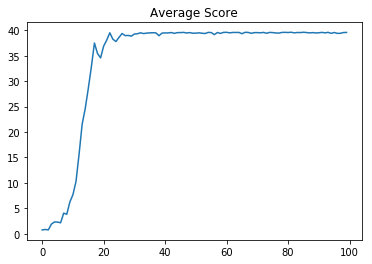

In [9]:
plt.plot(scores)
plt.title("Average Score")
plt.show()

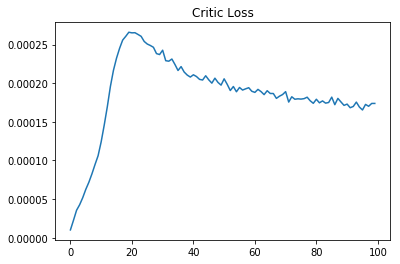

In [10]:
plt.plot(mean_loss_critic)
plt.title("Critic Loss")
plt.show()

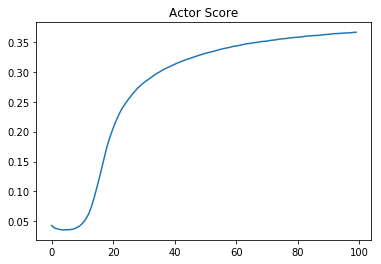

In [11]:
plt.plot(mean_score_actor)
plt.title("Actor Score")
plt.show()

In [12]:
torch.save(actor.state_dict(), "actor.pth")